# 错误坐姿提示
## 0 项目背景
- 每天你有多少时间是在坐着状态度过的？早上上班坐公交坐地铁是坐着，每天上班时基本也都在坐着，下班坐公交坐地铁还是在坐着，晚上回家看电视仍然在坐着，周末去餐厅吃饭是在坐着，开车也是在坐着，看电影还是在坐着。发现没有，你坐着的时间甚至比你躺在床上的时间还长！所以，非常有必要关注坐姿，这将决定你生活中绝大部分的时间是如何度过的。
- 小时候相信大家都听过老师的教导，上课要“腰挺直，手背后，不要在下面做小动作”，虽然老师已经一遍遍教诲过了，但是在毕业以后就基本抛之脑后了。现在我们在坐着的时候基本都是怎么舒服怎么来，各种躺着、瘫着（像之前很火的葛优瘫），这些都是显而易见的错误坐姿，时间长了我们自己也会觉得不舒服就会随着调整。

![](https://ai-studio-static-online.cdn.bcebos.com/795c4f74aacc4dc298a88442a62a63b7ec50e9bca50c4e68a26996109550ee29)


## 1 可行性步骤分析
- part1：通过PaddleHub完成人体骨骼关键点检测
- part2：根据关键点坐标状况判定坐姿状态

![](https://ai-studio-static-online.cdn.bcebos.com/f1d26df24a1b489e80b93d7046fe41fe93f90645a9594e3a9f343be980eee325)


## 2 代码实现
### 2.1  安装依赖库
- aistudio默认安装了PaddleHub, 本地运行的同学需要自行安装，可以到飞桨官网查看安装步骤：https://www.paddlepaddle.org.cn
- PaddleHub 的人体骨骼关键点检测库 [官方地址](https://www.paddlepaddle.org.cn/hubdetail?name=human_pose_estimation_resnet50_mpii&en_category=KeyPointDetection)


In [1]:
! hub install human_pose_estimation_resnet50_mpii==1.1.1

In [ ]:
!mkdir work/output_pose
!mkdir work/output_pose_test

In [2]:
# 测试是否安装成功
! hub run human_pose_estimation_resnet50_mpii --input_path "work/imgs/body01.jpg" --visualization True --output_dir "work/output_pose"

In [3]:
import os
import cv2
import paddlehub as hub
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
%matplotlib inline
import math
import glob

In [4]:
# 定义图片读取函数 
def show_img(img_path, size=8):
    '''
        文件读取图片显示
    '''
    im = imread(img_path)
    plt.figure(figsize=(size,size))
    plt.axis("off")
    plt.imshow(im)


def img_show_bgr(image,size=8):
    '''
        cv读取的图片显示
    '''
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(size,size))
    plt.imshow(image)
    
    plt.axis("off")
    plt.show() 

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


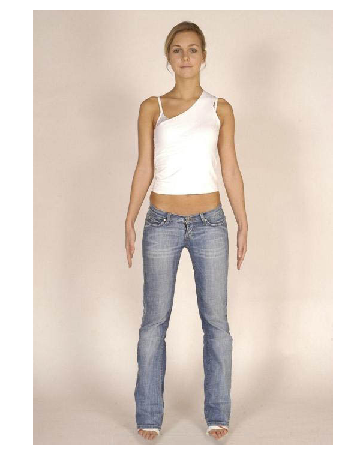

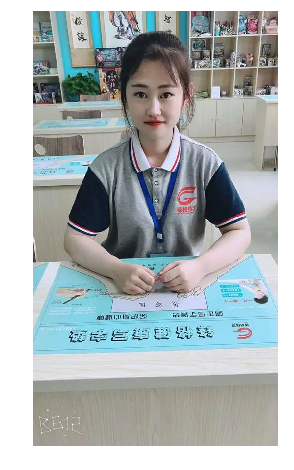

In [5]:
# 站姿
show_img('work/imgs/body01.jpg')
# 坐姿
show_img('work/imgs/005.jpg')

In [6]:
#通过代码获取图片中的关键点坐标
pose_estimation = hub.Module(name="human_pose_estimation_resnet50_mpii")
result_body = pose_estimation.keypoint_detection(paths=['work/imgs/body01.jpg'], visualization=True, output_dir="work/output_pose/")
result_sitting = pose_estimation.keypoint_detection(paths=['work/imgs/005.jpg'], visualization=True, output_dir="work/output_pose/")
print('站姿坐标',result_body)
print('坐姿坐标',result_sitting)

[2021-08-15 16:19:16,263] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


image saved in work/output_pose/body01time=1629015557.jpg
image saved in work/output_pose/005time=1629015558.jpg
站姿坐标 [{'path': 'work/imgs/body01.jpg', 'data': OrderedDict([('left_ankle', [192, 679]), ('left_knee', [203, 521]), ('left_hip', [213, 347]), ('right_hip', [291, 347]), ('right_knee', [307, 521]), ('right_ankle', [307, 672]), ('pelvis', [255, 347]), ('thorax', [255, 166]), ('upper_neck', [255, 120]), ('head_top', [255, 22]), ('right_wrist', [161, 354]), ('right_elbow', [182, 264]), ('right_shoulder', [192, 166]), ('left_shoulder', [317, 166]), ('left_elbow', [333, 271]), ('left_wrist', [348, 362])])}]
坐姿坐标 [{'path': 'work/imgs/005.jpg', 'data': OrderedDict([('left_ankle', [234, 676]), ('left_knee', [234, 657]), ('left_hip', [213, 592]), ('right_hip', [286, 583]), ('right_knee', [276, 657]), ('right_ankle', [276, 638]), ('pelvis', [244, 555]), ('thorax', [255, 324]), ('upper_neck', [250, 240]), ('head_top', [250, 92]), ('right_wrist', [177, 537]), ('right_elbow', [78, 472]), (

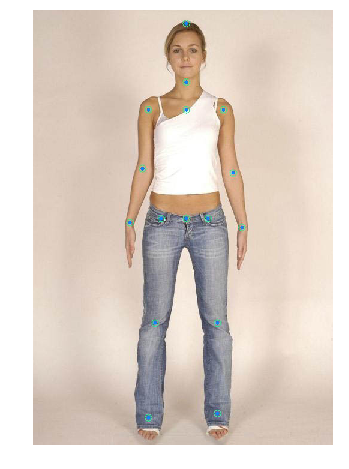

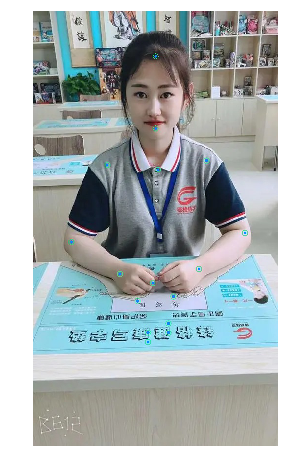

In [8]:
show_img('work/output_pose/body01.jpg')
show_img('work/output_pose/005.jpg')

###  2.2 理论分析
> - 由此我们发现，坐姿只需要上半身关键点的坐标就可以了
- 用到的关键点有：
- 头顶 head_top
- 脖子 upper_neck
- 胸腔 thorax
- 右手腕 right_wrist
- 右肘 right_elbow
- 右肩膀right_shoulder
- 左手腕 left_wrist
- 左肘 left_elbow
- 左肩膀left_shoulder
>- 本项目主要用到 head_top、upper_neck、thorax、right_shoulder、left_shoulder
- 1 判断歪头
根据head_top坐标和right_shoulder、left_shoulder中心点的连线偏移角度，来判定头部倾斜角度，如下图（线有点略歪）

![](https://ai-studio-static-online.cdn.bcebos.com/46a56b3e9a8446fd879f992a1020c0243e1c164fc0f14d39a69c9548d339875b)

箭头所指便是偏移角，这里设定的阈值为10度
- 2 判断低头
根据头顶到脖子的距离和脖子到胸腔的距离进行比较（个人觉得这个方法有点牵强，有好想法的小伙伴可评论区）

In [113]:
def Center_Point(point_1, point_2):
    """
    根据两点坐标计算中心点坐标
    :param point_1: 点1坐标
    :param point_2: 点2坐标
    """
    center_x =  math.fabs((point_1[0]-point_2[0])/2) + min(point_1[0], point_2[0])
    center_y =  math.fabs((point_1[1]-point_2[1])/2) + min(point_1[1], point_2[1])
    center = [center_x, center_y]
    return center

def Cal_Ang(point_1, point_2, point_3):
    """
    根据三点坐标计算夹角
    :param point_1: 点1坐标
    :param point_2: 点2坐标
    :param point_3: 点3坐标
    :return: 点2的夹角(中心点)
    """
    a=math.sqrt((point_2[0]-point_3[0]) * (point_2[0]-point_3[0])+(point_2[1]-point_3[1]) * (point_2[1]-point_3[1]))
    b=math.sqrt((point_1[0]-point_3[0]) * (point_1[0]-point_3[0])+(point_1[1]-point_3[1]) * (point_1[1]-point_3[1]))
    c=math.sqrt((point_1[0]-point_2[0]) * (point_1[0]-point_2[0])+(point_1[1]-point_2[1]) * (point_1[1]-point_2[1]))
    B=math.degrees(math.acos((b*b-a*a-c*c)/(-2*a*c)))
    return B

def Head_Sitting(left_shoulder, right_shoulder, head_top):
    """
    判断坐姿头部是否倾斜
    left_shoulder: 左肩膀
    right_shoulder: 右肩膀
    head_top: 头顶
    设定角度阈值为10度，即头部偏离垂直线角度超过20度为头部倾斜
    """
    center_point = Center_Point(left_shoulder, right_shoulder)
    head_angle = Cal_Ang(head_top, center_point, right_shoulder)
    if head_angle <= 80 or head_angle >= 100 :
        return print("头部倾斜")
    else:
        return None

In [114]:
def Head_Down(head_top, upper_neck, thorax):
    """
    将头顶到脖子的距离和脖子到胸腔的距离进行比较
    """
    head_neck = math.fabs(head_top[1]-upper_neck[1])
    neck_thorax = math.fabs(thorax[1]-upper_neck[1])
    if head_neck/3.0 > neck_thorax:
        return print("低头状态")
    else:
        return None

In [101]:
# 定义读取路径下所有图片的函数
def walk_type(path, file_type):
    paths = []
    paths = glob.glob(os.path.join(path,#存放图片的文件夹路径
                                   file_type # 文件类型，*代表所有文件
                                   )
                      )# path下所有file_type类型的文件的路径列表
    return paths

In [103]:
paths = walk_type('work/img_test','*.jpg')
print(paths)

['work/img_test/06.jpg', 'work/img_test/005.jpg', 'work/img_test/03.jpg']


In [115]:
def Sitting_Judge(paths):
    """
    姿态提示
    """
    result_sitting_test = pose_estimation.keypoint_detection(paths=[paths], visualization=True, output_dir="work/output_pose_test/")
    Head_Sitting(result_sitting_test[0]['data']['left_shoulder'], result_sitting_test[0]['data']['right_shoulder'], result_sitting_test[0]['data']['head_top'])
    Head_Down(result_sitting_test[0]['data']['head_top'], result_sitting_test[0]['data']['upper_neck'], result_sitting_test[0]['data']['thorax'])
    print('----------------------------------------------')

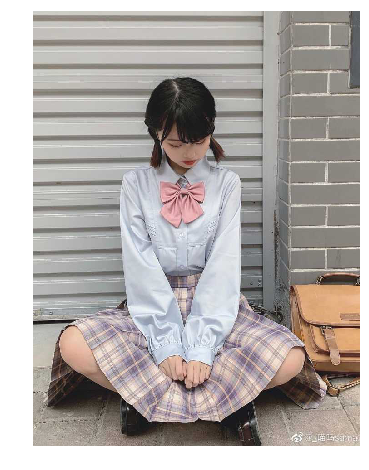

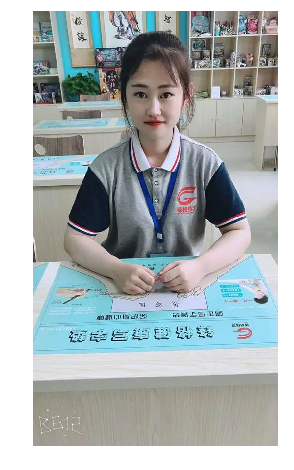

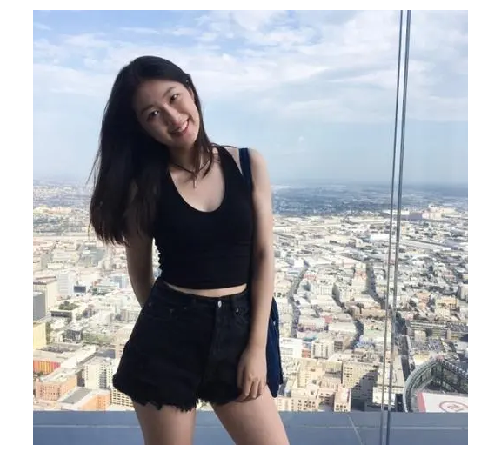

In [117]:
# 错误坐姿图有点难找，便找了几张低头，歪头的图试试效果
for i in range(len(paths)):
    show_img(paths[i])

In [120]:
for i in range(len(paths)):
    print('第'+ str(i) +  '张图' )
    Sitting_Judge(paths[i])

第0张图
image saved in work/output_pose_test/06.jpg
低头状态
----------------------------------------------
第1张图
image saved in work/output_pose_test/005.jpg
----------------------------------------------
第2张图
image saved in work/output_pose_test/03.jpg
头部倾斜
----------------------------------------------


## 小结
> - 以上是作者参加AI创造营产出的项目，不同见解欢迎各位大佬指正
> - 如若存在问题，可在评论区留言，作者会不时为大家讲解
> - 作者aistudio主页链接，欢迎各位互粉、提问：[aistudio](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/539945)